<div style="text-align: center;">
  <h1>Transaction Success Rate Prediction</h1>
  <h2>Developing & Optimizing Predictive Models for Transaction Success Estimation</h2>
  <img src="imgs/6670985.jpg" alt="Transaction Analysis Overview" width="1000" height="500"/>
  <p>
    <a href="http://www.freepik.com">Freepik</a>
  </p>
</div>



### Author: Umar Kabir
#### Date: March 17, 2025

### Introduction
This notebook implements an end-to-end machine learning pipeline to predict the probability of transaction success based on historical transaction data. We'll follow best practices in model development, optimization, and evaluation with a focus on business-relevant metrics.
<a id="home"></a>

### Table of Contents
1. [Setup & Data Loading](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#preprocessing)
4. [Baseline Model](#baseline)
5. [Advanced Models](#advanced)
6. [Hyperparameter Optimization](#hyperparameter)
7. [Cross-Validation & Model Selection](#crossvalidation)
8. [Model Evaluation & Performance Reporting](#evaluation)
9. [Conclusions & Next Steps](#conclusions)


In [1]:
import sys
import os

# Get the absolute path of the parent directory
sys.path.insert(0, os.path.abspath('../'))

# import the necessary packages
from src.dependencies import *
from src.utils import *


c:\Users\USER\Documents\Documents\Personal Development\Portfolio Projects\transaction_success_optimization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="eda"></a>
## 2. Exploratory Data Analysis  

[Back to Top](#home)

Successfully loaded dataset with 5463 rows and 16 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   payment_method_rolling_success_scaled  5443 non-null   float64
 1   hour                                   5463 non-null   int64  
 2   merchant_transaction_count_log         5463 non-null   float64
 3   payment_location_success_rate_scaled   5463 non-null   float64
 4   device_type_pos                        5463 non-null   bool   
 5   amount_bin_encoded                     5463 non-null   int64  
 6   device_type_mobile                     5463 non-null   bool   
 7   retry_count                            5463 non-null   int64  
 8   payment_method_ussd                    5463 non-null   bool   
 9   payment_method_rolling_success         5443 non-null   float64
 10  merchant_succ

None

Missing values per column:
payment_method_rolling_success_scaled    20
hour                                      0
merchant_transaction_count_log            0
payment_location_success_rate_scaled      0
device_type_pos                           0
amount_bin_encoded                        0
device_type_mobile                        0
retry_count                               0
payment_method_ussd                       0
payment_method_rolling_success           20
merchant_success_rate_scaled              0
network_latency_scaled                    0
has_retry                                 0
result_numeric                            0
transaction_id                            0
timestamp                                 0
dtype: int64
Target Distribution:
Successful transactions: 93.61%
Failed transactions: 6.39%


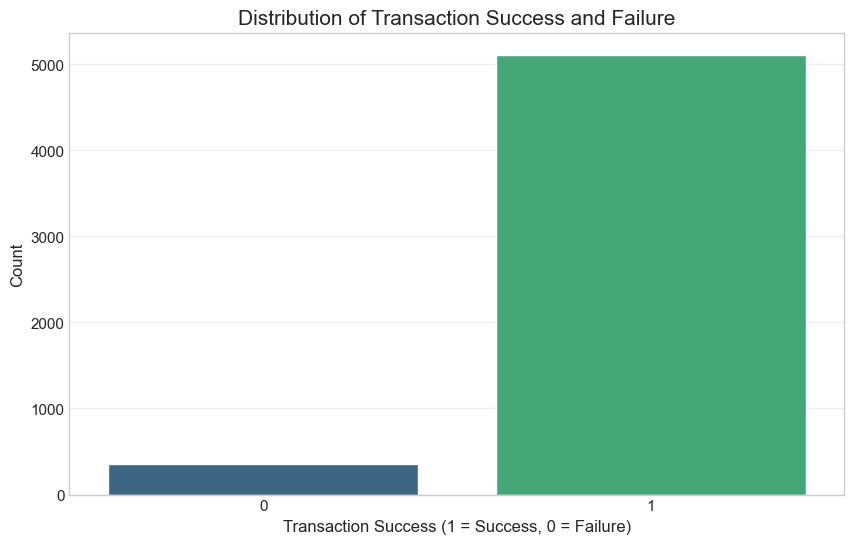

In [2]:
# Load dataset
try:
    df = pd.read_csv('../data/processed/processed_transaction_data.csv')
    print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print("Transaction data file not found. Try changing directory.")

display(df.info())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check target distribution
target_distribution = df['result_numeric'].value_counts(normalize=True) * 100
print("Target Distribution:")
print(f"Successful transactions: {target_distribution[1]:.2f}%")
print(f"Failed transactions: {target_distribution[0]:.2f}%")

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='result_numeric', data=df, palette='viridis')
plt.title('Distribution of Transaction Success and Failure', fontsize=15)
plt.xlabel('Transaction Success (1 = Success, 0 = Failure)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()


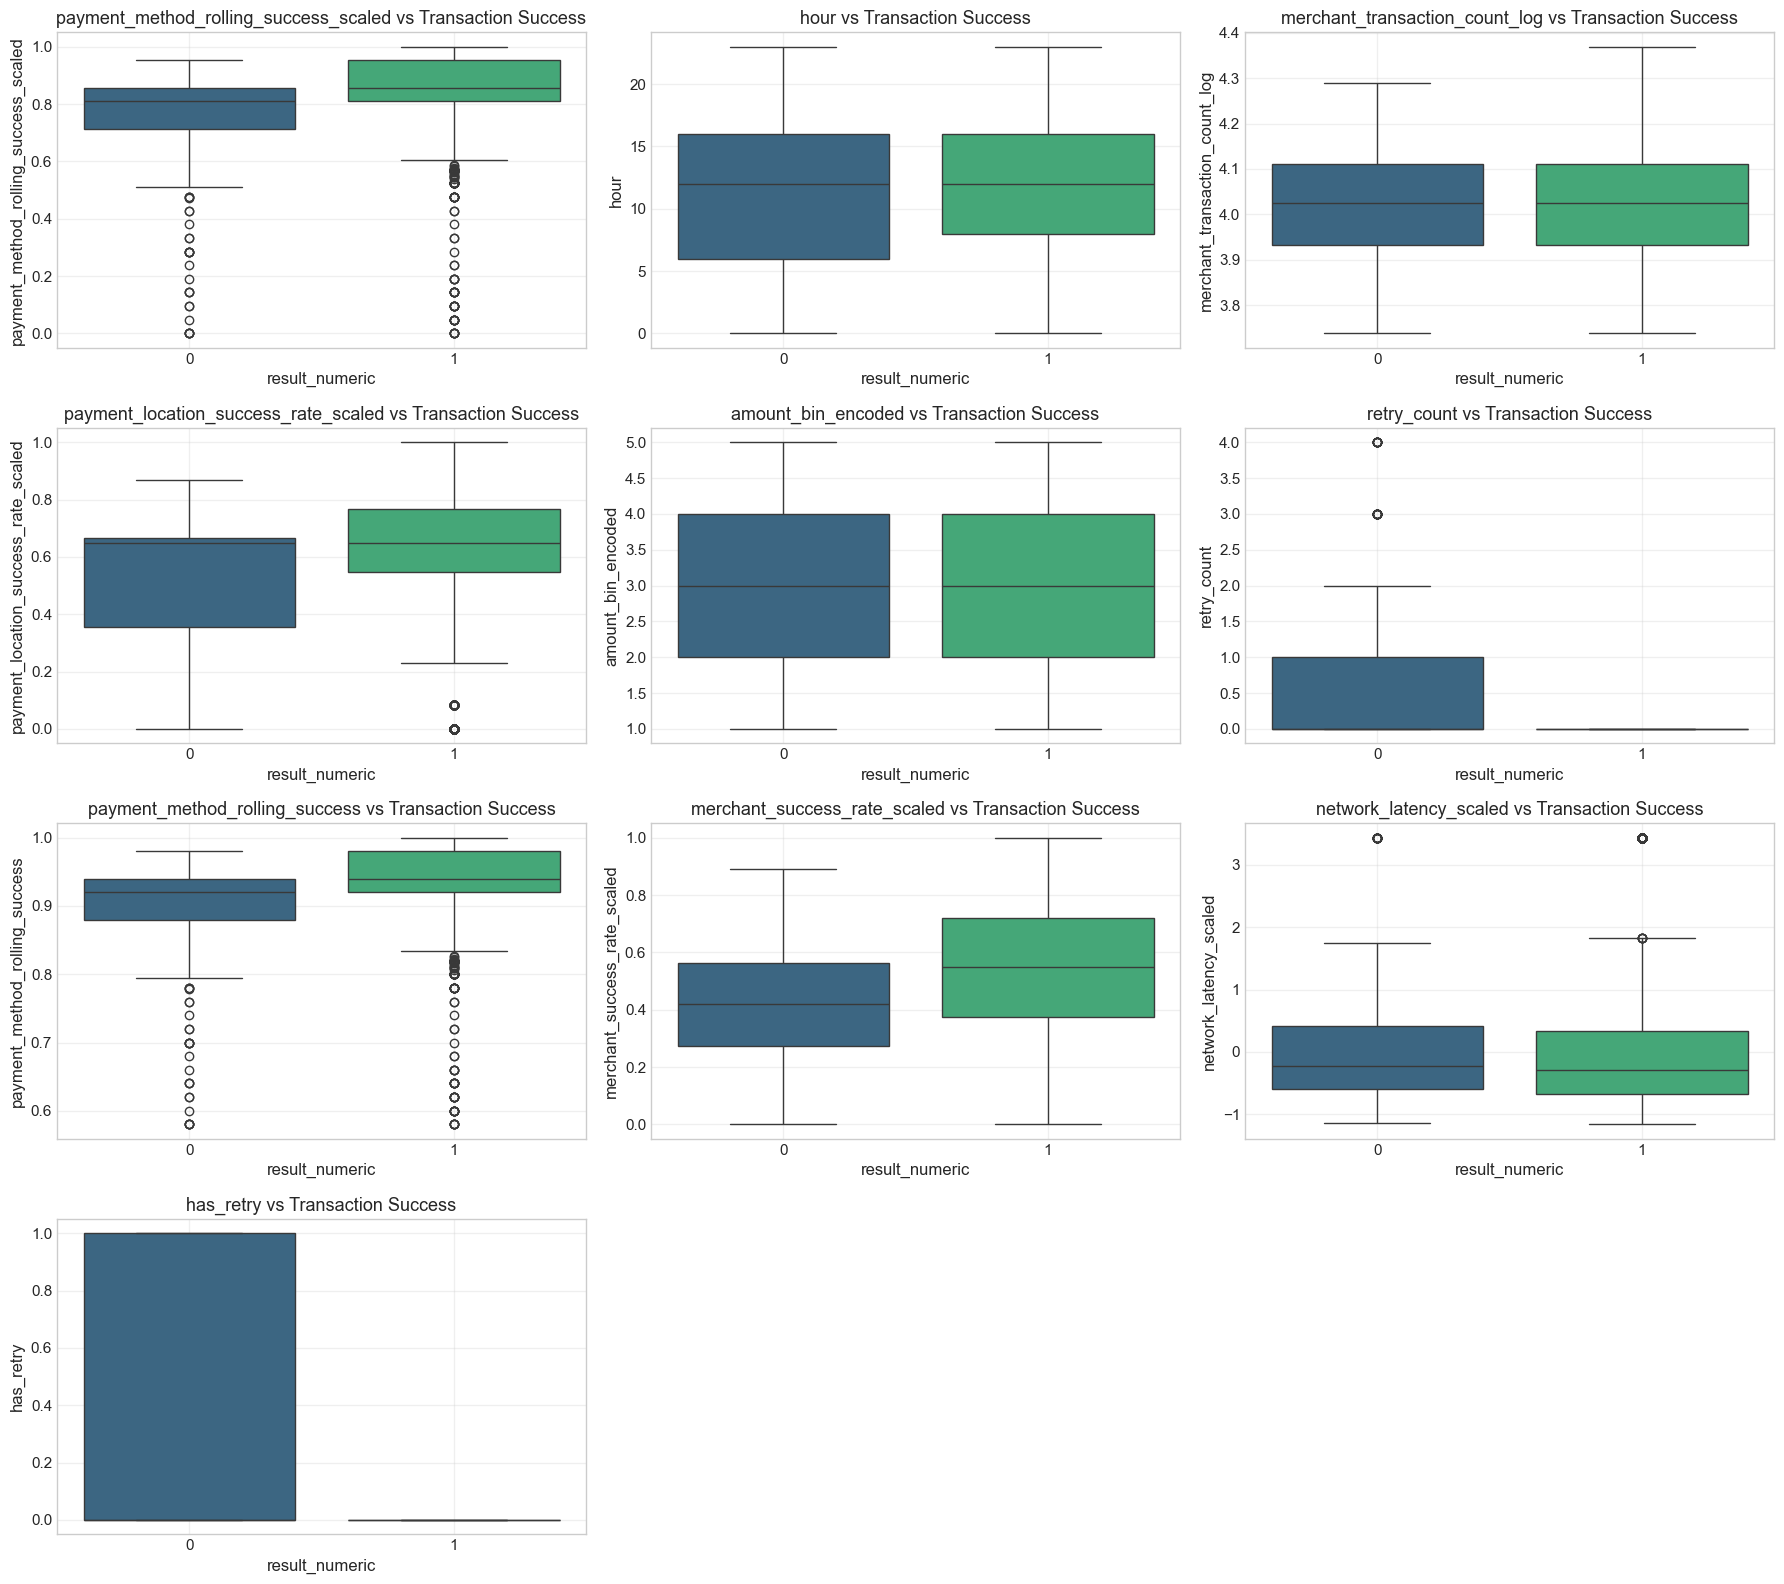

In [3]:

# Select numerical features dynamically, excluding the target variable 'result'
numerical_features = df.select_dtypes(include=['number']).columns.drop('result_numeric', errors='ignore')

# Determine subplot grid dimensions
num_features = len(numerical_features)
rows = (num_features // 3) + (num_features % 3 > 0)  # Create enough rows for all plots

# Create box plots
plt.figure(figsize=(18, rows * 4))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(x='result_numeric', y=feature, data=df, palette='viridis')
    plt.title(f'{feature} vs Transaction Success', fontsize=13)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


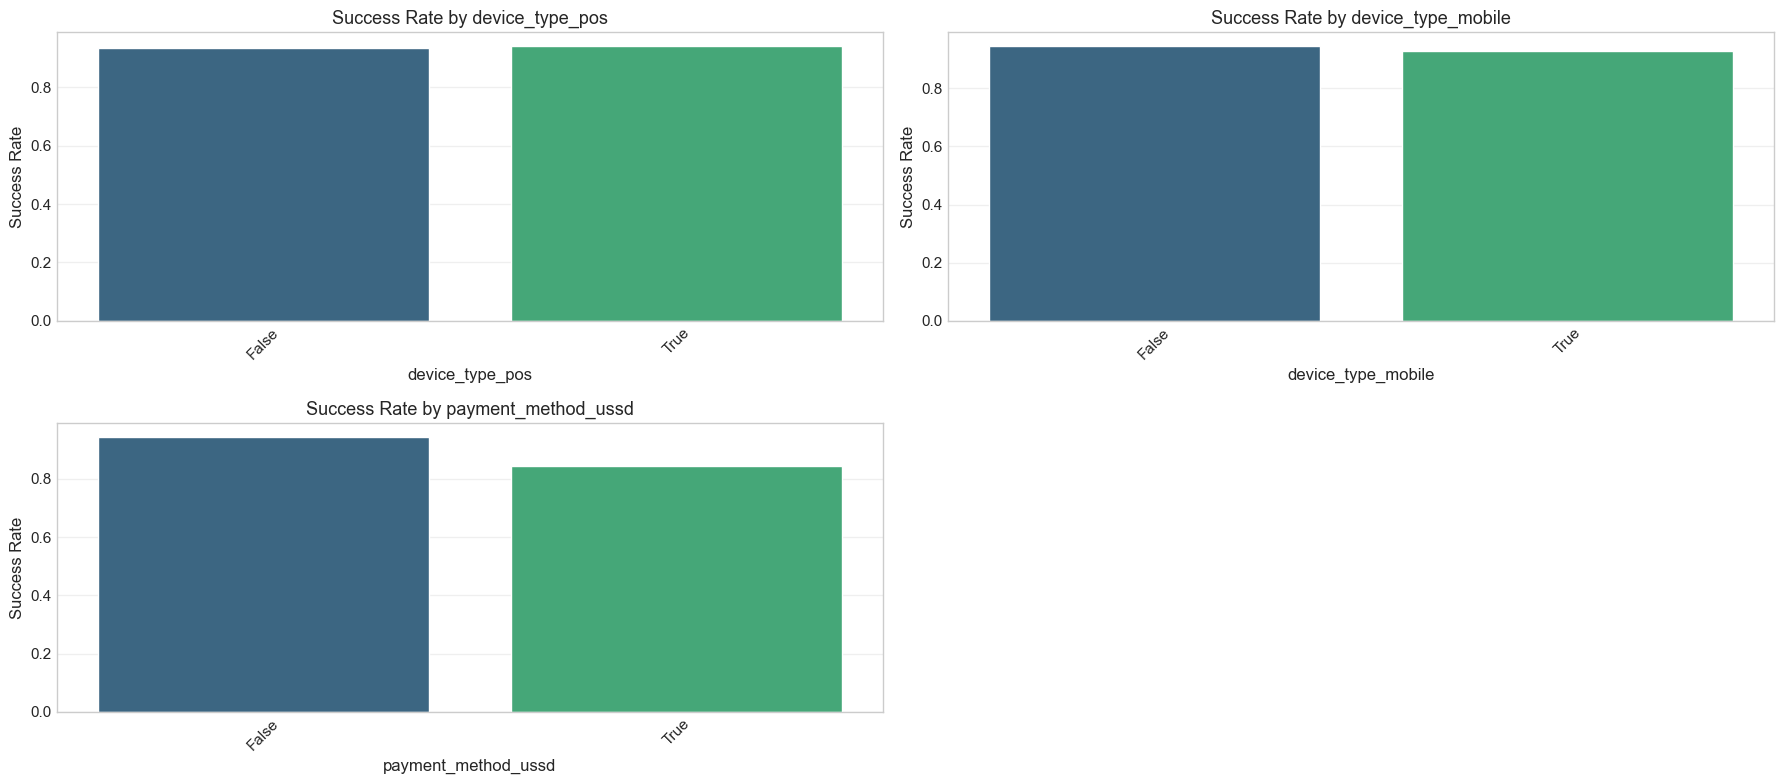

In [4]:
# Select categorical features dynamically, excluding specific columns
exclude_columns = ['result_numeric', 'timestamp', 'transaction_id']

categorical_features = df.select_dtypes(exclude=['number']).columns.drop(exclude_columns, errors='ignore')


# Determine subplot grid dimensions
num_features = len(categorical_features)
rows = (num_features // 2) + (num_features % 2 > 0)  # Create enough rows for all plots

# Create bar plots for categorical features
plt.figure(figsize=(18, rows * 4))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(rows, 2, i)
    
    # Calculate result_numeric rates
    success_rates = df.groupby(feature)['result_numeric'].mean().sort_values(ascending=False)
    
    # Plot
    sns.barplot(x=success_rates.index, y=success_rates.values, palette='viridis')
    plt.title(f'Success Rate by {feature}', fontsize=13)
    plt.ylabel('Success Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


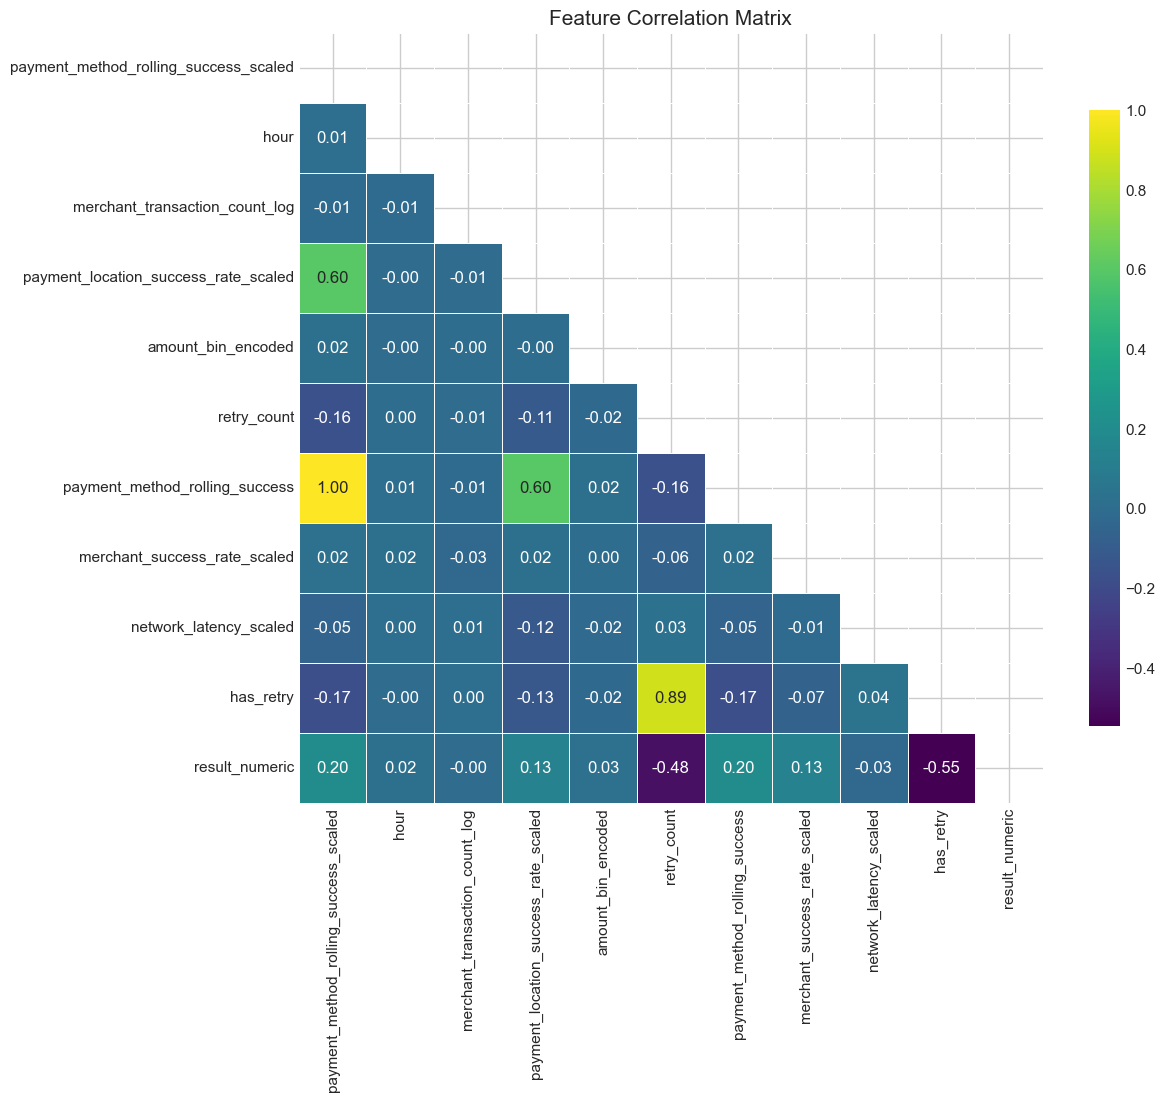

In [5]:
# Select numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlations
corr = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='viridis', annot=True, fmt='.2f', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=15)
plt.show()

<a id="preprocessing"></a>
## 3. Data Preprocessing 

[Back to Top](#home)

In [6]:
X = df.drop(columns=['result_numeric', 'transaction_id', 'timestamp'])
y = df['result_numeric']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Create preprocessing pipeline
# Numerical features: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Fit and transform the entire dataset
X = preprocessor.fit_transform(X)
# Split data into training and testing sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Convert transformed arrays to DataFrame
processed_feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(X_train, columns=processed_feature_names)
X_test_df = pd.DataFrame(X_test, columns=processed_feature_names)

print(f"Processed Training set shape: {X_train_df.shape}")
print(f"Processed Testing set shape: {X_test_df.shape}")

# Ensure y is a NumPy array before using np.bincount()
y_train_arr, y_test_arr = np.array(y_train), np.array(y_test)

# Check class distribution
print(f"Training set class distribution: {np.bincount(y_train_arr)}")
print(f"Testing set class distribution: {np.bincount(y_test_arr)}")

Categorical features: []
Numerical features: ['payment_method_rolling_success_scaled', 'hour', 'merchant_transaction_count_log', 'payment_location_success_rate_scaled', 'amount_bin_encoded', 'retry_count', 'payment_method_rolling_success', 'merchant_success_rate_scaled', 'network_latency_scaled', 'has_retry']
Processed Training set shape: (4370, 13)
Processed Testing set shape: (1093, 13)
Training set class distribution: [ 279 4091]
Testing set class distribution: [  70 1023]


<a id="baseline"></a>
## 4. Baseline Model: Logistic Regression

[Back to Top](#home)

Class weights: {0: np.float64(7.831541218637993), 1: np.float64(0.5340992422390614)}
Training completed in 0.01 seconds

Baseline Logistic Regression Model Performance:
Accuracy: 0.7740
Precision: 0.9675
Recall: 0.7849
F1 Score: 0.8667
ROC AUC: 0.8030


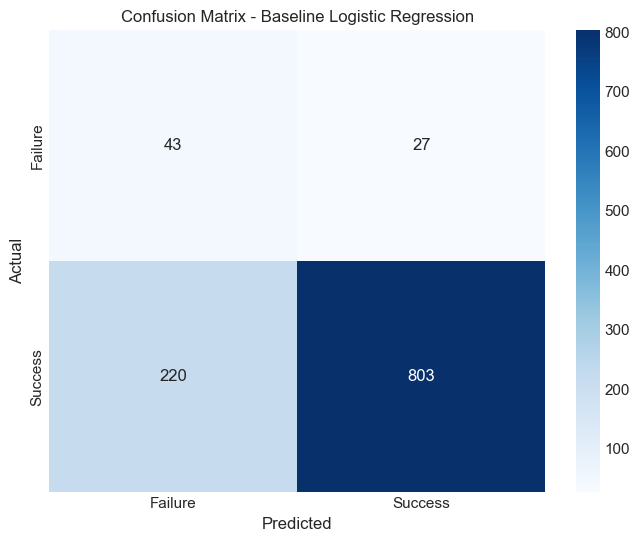

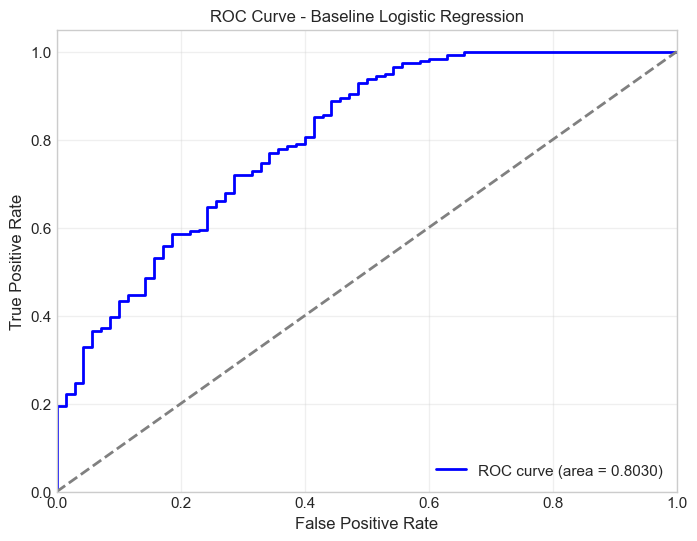

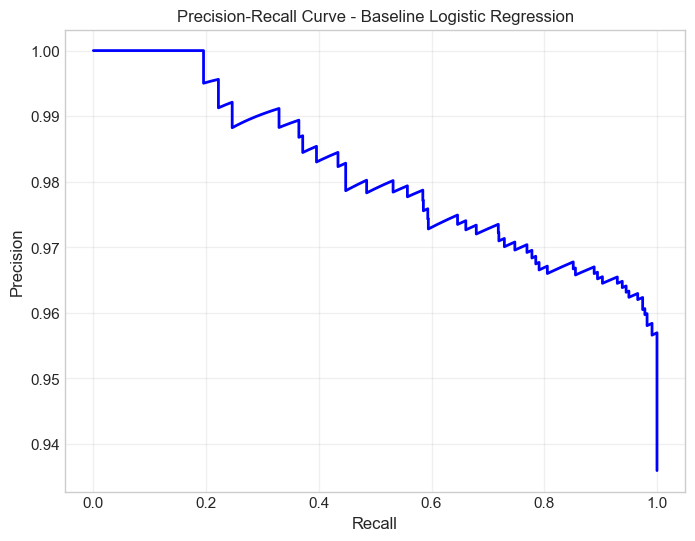

In [7]:
# Create the full pipeline with preprocessing and logistic regression
# Calculate class weights to handle imbalance
class_weights = {0: 1, 1: 1}  # Will be adjusted if imbalanced
if len(np.unique(y_train)) == 2:
    # Calculate class weights inversely proportional to class frequencies
    class_counts = np.bincount(y_train)
    total = len(y_train)
    class_weights = {i: total / (len(np.unique(y_train)) * count) for i, count in enumerate(class_counts)}
    
print(f"Class weights: {class_weights}")

# Define the full pipeline
baseline_pipeline = Pipeline([
    ('classifier', LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight=class_weights,
        solver='liblinear'
    ))
])

# Fit the model
start_time = time.time()
baseline_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Make predictions on the test set
y_pred = baseline_pipeline.predict(X_test)
y_pred_proba = baseline_pipeline.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print evaluation metrics
print("\nBaseline Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Logistic Regression')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Baseline Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Baseline Logistic Regression')
plt.grid(alpha=0.3)
plt.show()

<a id="advanced"></a>
## 5. Advanced Models

[Back to Top](#home)

### 5.1 Random Forest


Random Forest Performance:
Training time: 0.17 seconds
Accuracy: 0.9277
Precision: 0.9583
Recall: 0.9648
F1 Score: 0.9615
ROC AUC: 0.7972


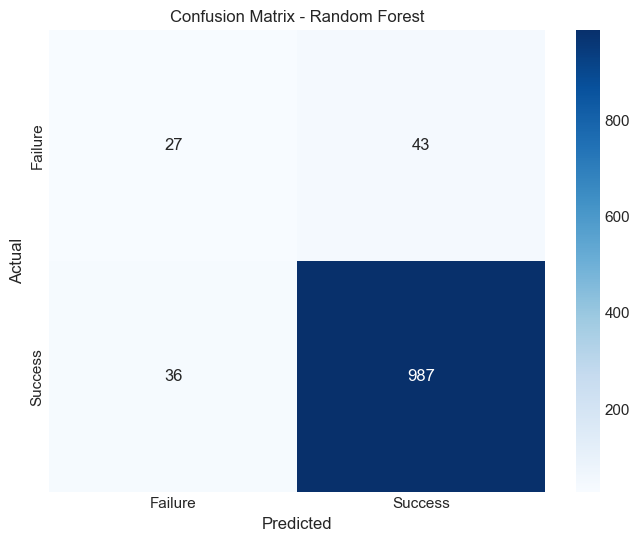

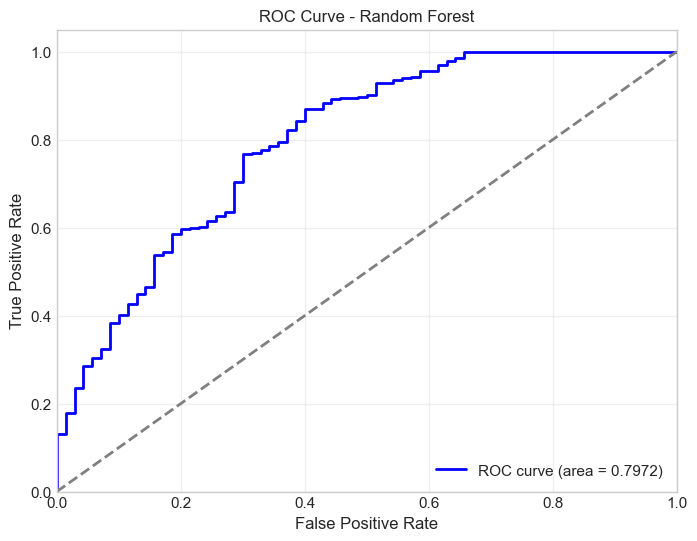

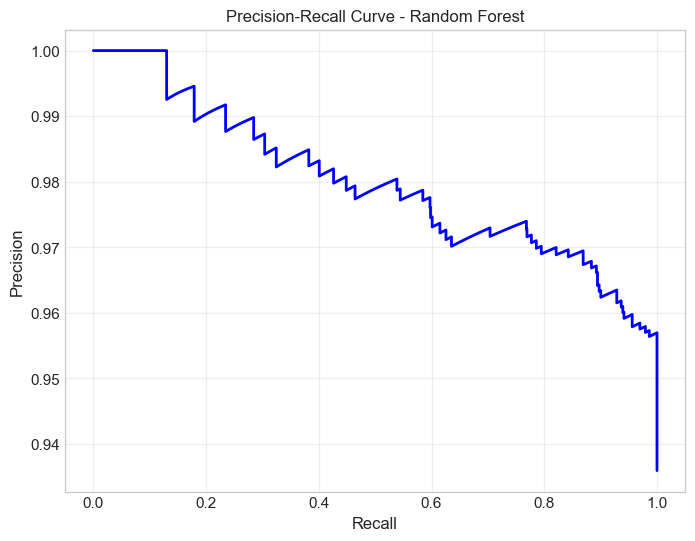

In [9]:
# Create Random Forest model with preprocessing
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight=class_weights,
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate Random Forest model
rf_results = evaluate_model(rf_pipeline, X_train, X_test, y_train, y_test, "Random Forest")

### 5.2 XGBoost


XGBoost Performance:
Training time: 0.22 seconds
Accuracy: 0.9579
Precision: 0.9570
Recall: 1.0000
F1 Score: 0.9780
ROC AUC: 0.7786


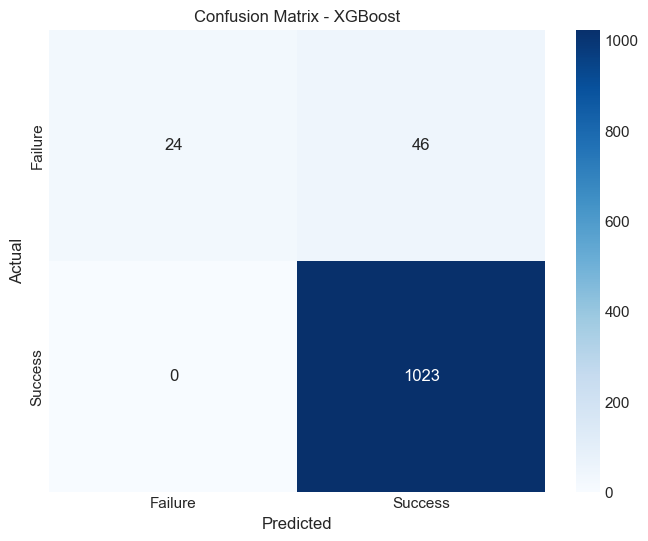

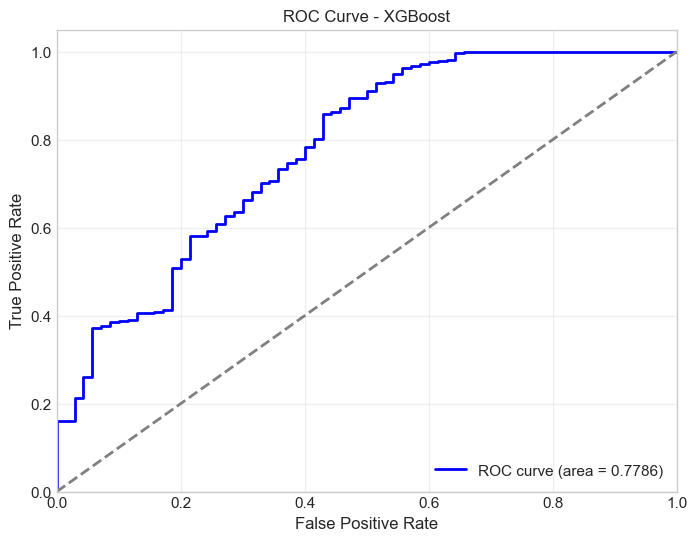

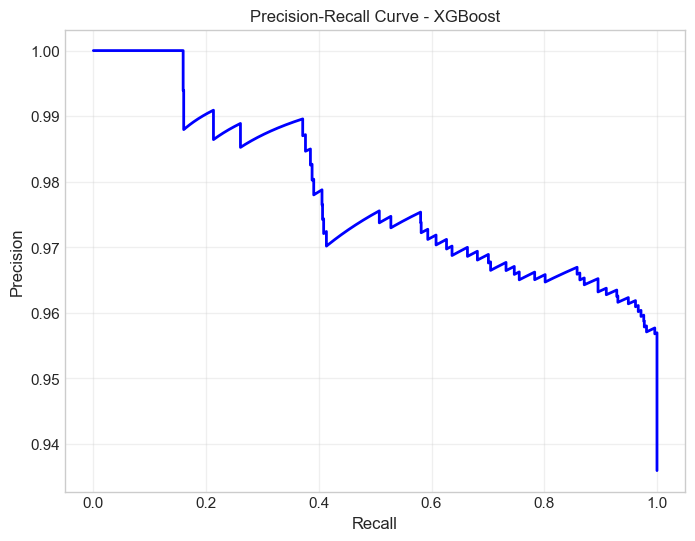

In [10]:
# Create XGBoost model with preprocessing
xgb_pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=class_weights[0]/class_weights[1] if 0 in class_weights and 1 in class_weights else 1,
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate XGBoost model
xgb_results = evaluate_model(xgb_pipeline, X_train, X_test, y_train, y_test, "XGBoost")

### 5.3 Neural Network 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7448 - loss: 0.5709 - val_accuracy: 0.9428 - val_loss: 0.2092
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9359 - loss: 0.2381 - val_accuracy: 0.9634 - val_loss: 0.1502
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.2057 - val_accuracy: 0.9634 - val_loss: 0.1431
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9560 - loss: 0.1785 - val_accuracy: 0.9634 - val_loss: 0.1408
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9563 - loss: 0.1787 - val_accuracy: 0.9634 - val_loss: 0.1403
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9560 - loss: 0.1734 - val_accuracy: 0.9634 - val_loss: 0.1404
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9539 - loss: 0.1794 - val_accuracy: 0.9634 - val_loss: 0.1400
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.1877 - val_accuracy: 0.9634 - val_

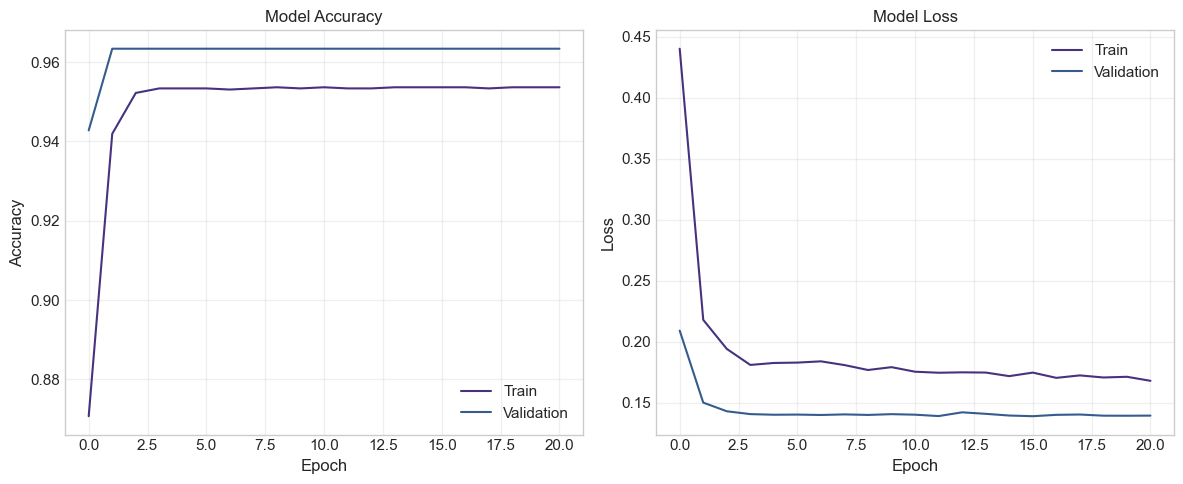

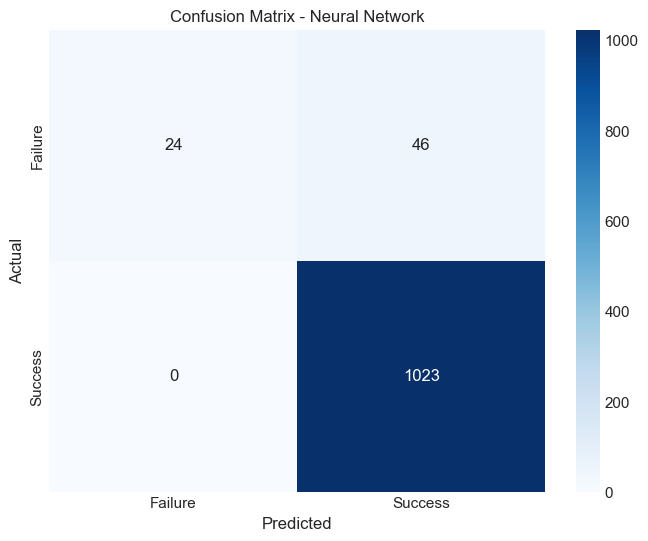

In [ ]:
# Preprocess the data first to get input dimensions for the NN

input_dim = X_train.shape[1]
activation = 'relu'
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
output_activation = 'sigmoid'

# Create early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Create and train the model
nn_model = create_nn_model(input_dim, activation, optimizer, loss, metrics, output_activation)
print(nn_model.summary())

# Fit the model
start_time = time.time()
history = nn_model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
train_time = time.time() - start_time



# Evaluate the model
y_pred_proba = nn_model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("\nNeural Network Performance:")
print(f"Training time: {train_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create and plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

# Store NN results
nn_results = {
    'model_name': 'Neural Network',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'train_time': train_time,
    'y_pred_proba': y_pred_proba
}

### 5.4 Compare Model Performances


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,Training Time (s)
3,Neural Network,0.957914,0.956969,1.000000,0.978011,0.818768,5.661194
2,XGBoost,0.957914,0.956969,1.000000,0.978011,0.778648,0.224451
1,Random Forest,0.927722,0.958252,0.964809,0.961520,0.797207,0.168292
0,Logistic Regression,0.774016,0.967470,0.784946,0.866703,0.803044,5.661194


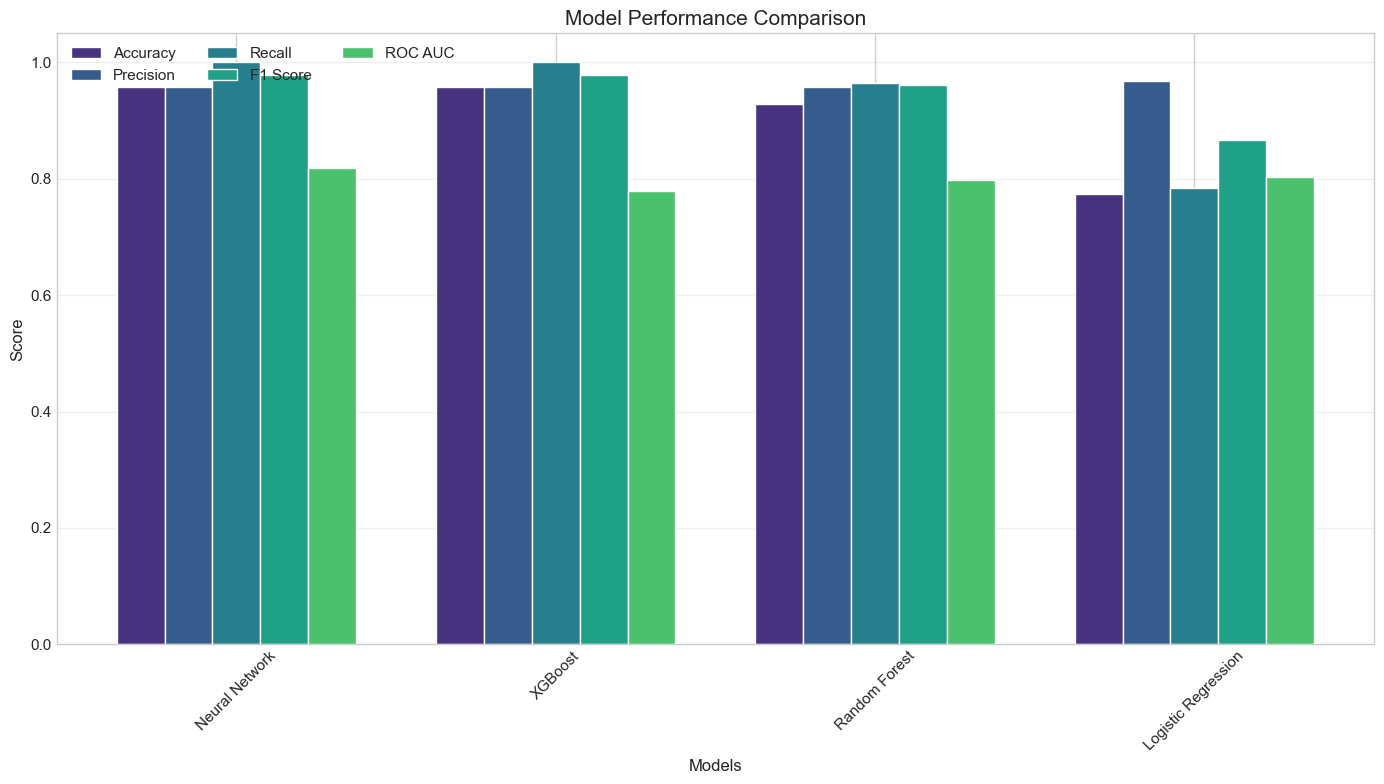

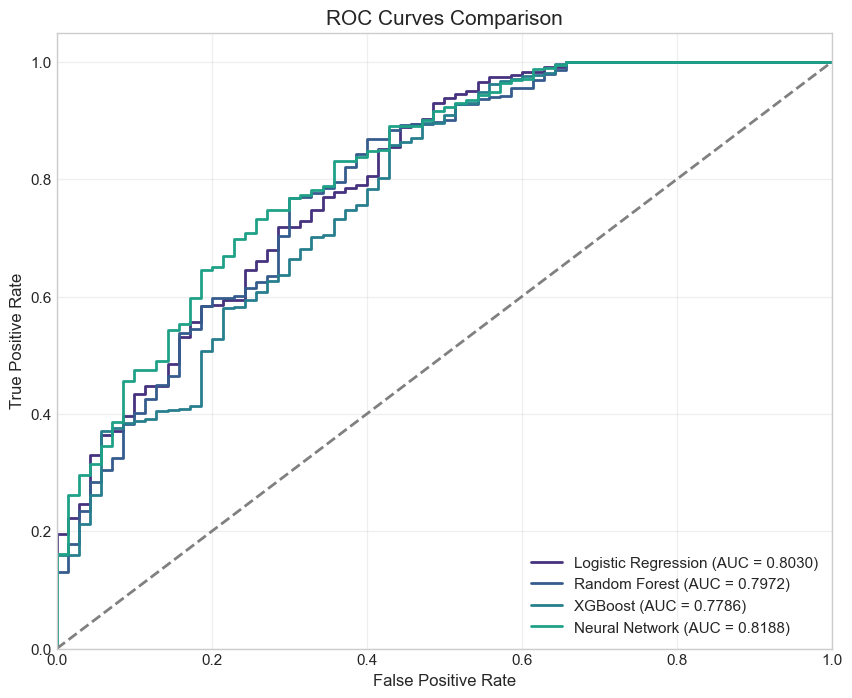

In [12]:
# Collect results from all models
models_results = [
    {'model_name': 'Logistic Regression', 
     'accuracy': accuracy_score(y_test, baseline_pipeline.predict(X_test)),
     'precision': precision_score(y_test, baseline_pipeline.predict(X_test)),
     'recall': recall_score(y_test, baseline_pipeline.predict(X_test)),
     'f1': f1_score(y_test, baseline_pipeline.predict(X_test)),
     'roc_auc': roc_auc_score(y_test, baseline_pipeline.predict_proba(X_test)[:, 1]),
     'train_time': train_time,
     'y_pred_proba': baseline_pipeline.predict_proba(X_test)[:, 1]
    },
    rf_results,
    xgb_results,
    nn_results
]

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1 Score': result['f1'],
        'ROC AUC': result['roc_auc'],
        'Training Time (s)': result['train_time']
    }
    for result in models_results
])

# Sort by F1 score (or another preferred metric)
comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

# Display comparison
print("\nModel Performance Comparison:")
display(comparison_df)

# Visualize model comparison
plt.figure(figsize=(14, 8))

# Plot comparison of different metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
x = np.arange(len(models_results))
width = 0.15
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    plt.bar(x + offset, comparison_df[metric], width, label=metric)
    multiplier += 1

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Comparison', fontsize=15)
plt.xticks(x + width * 2, comparison_df['Model'], rotation=45)
plt.legend(loc='upper left', ncols=3)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for result in models_results:
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, lw=2, label=f"{result['model_name']} (AUC = {result['roc_auc']:.4f})")

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=15)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

<a id="hyperparameter"></a>
## 6. Hyperparameter Optimization

[Back to Top](#home)

### 6.1 Grid Search for XGBoost

In [13]:
# Define parameter grid for XGBoost
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # Can also use 'roc_auc', 'precision', etc.
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_



Fitting 5 folds for each of 324 candidates, totalling 1620 fits



Optimized XGBoost Performance:
Training time: 0.17 seconds
Accuracy: 0.9579
Precision: 0.9570
Recall: 1.0000
F1 Score: 0.9780
ROC AUC: 0.7945


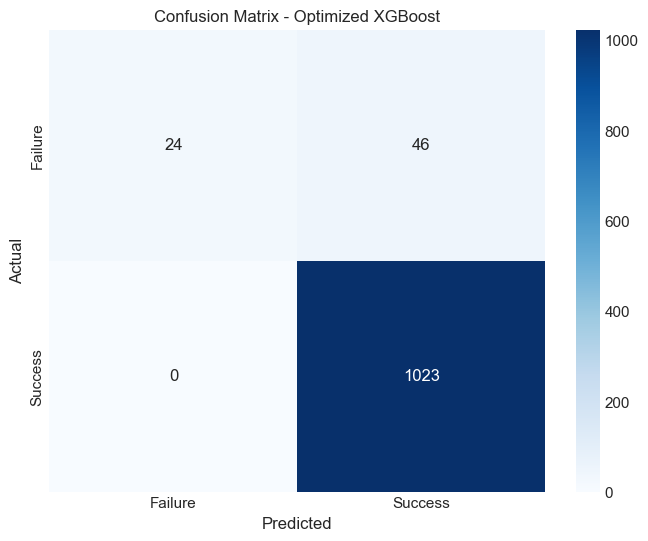

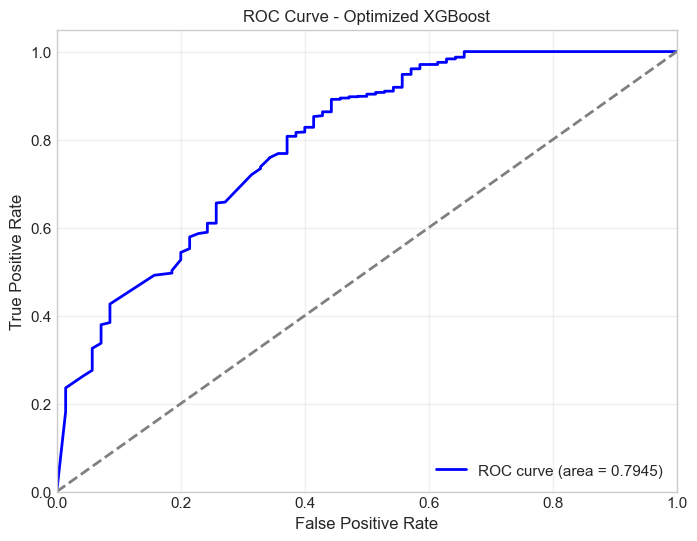

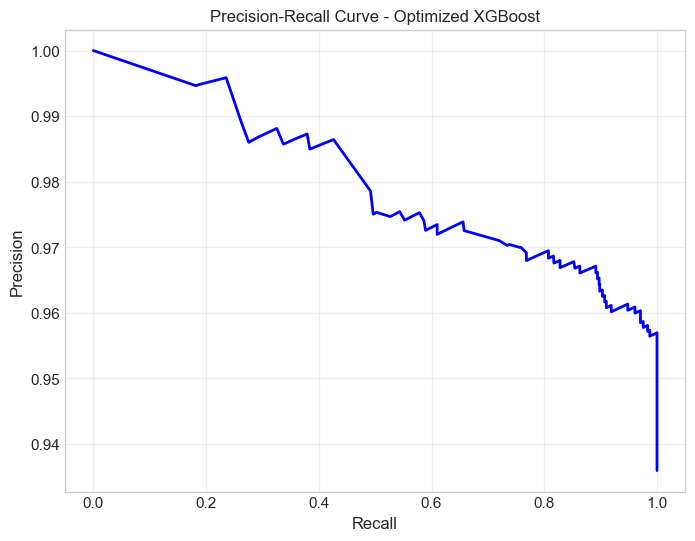

In [14]:
# Create optimized XGBoost with best parameters
optimized_xgb_pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        learning_rate=best_params['classifier__learning_rate'],
        subsample=best_params['classifier__subsample'],
        colsample_bytree=best_params['classifier__colsample_bytree'],
        gamma=best_params['classifier__gamma'],
        objective='binary:logistic',
        scale_pos_weight=class_weights[0]/class_weights[1] if 0 in class_weights and 1 in class_weights else 1,
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate optimized model
optimized_xgb_results = evaluate_model(
    optimized_xgb_pipeline, X_train, X_test, y_train, y_test, "Optimized XGBoost"
)

### 6.2 Bayesian Optimization using Optuna

In [15]:
# Compute class weights (if y_train contains 0s and 1s)
unique_classes = np.unique(y_train)
if len(unique_classes) == 2:  # Ensure binary classification
    class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
    class_weight_ratio = class_weights[0] / class_weights[1] if 0 in unique_classes and 1 in unique_classes else 1
else:
    class_weight_ratio = 1  # Default to no class weighting if not binary

# Define an objective function for Optuna
def objective(trial):
    # Hyperparameter suggestions
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'binary:logistic',
        'scale_pos_weight': class_weight_ratio,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create XGBoost model
    model = Pipeline([
        ('classifier', xgb.XGBClassifier(**params))
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X_train, y_train, 
        cv=5, 
        scoring='f1',  # Using F1 score as our optimization target
        n_jobs=-1
    )
    
    # Return mean F1 score
    return cv_scores.mean()

# Example of running Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("\nBest trial:")
trial = study.best_trial
print(f"  Value (F1 Score): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-03-20 21:59:36,981] A new study created in memory with name: no-name-dc6e8a52-7468-41db-a8fb-15e842880ba9
[I 2025-03-20 21:59:37,272] Trial 0 finished with value: 0.966903073286052 and parameters: {'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.0792309471426453, 'subsample': 0.9472948469010541, 'colsample_bytree': 0.9712842964733568, 'gamma': 0.25709054331024755, 'min_child_weight': 10}. Best is trial 0 with value: 0.966903073286052.
[I 2025-03-20 21:59:37,623] Trial 1 finished with value: 0.9670251166323857 and parameters: {'n_estimators': 277, 'max_depth': 10, 'learning_rate': 0.048379167724336224, 'subsample': 0.756851823681885, 'colsample_bytree': 0.6440868282657685, 'gamma': 0.18719829338203997, 'min_child_weight': 10}. Best is trial 1 with value: 0.9670251166323857.
[I 2025-03-20 21:59:37,850] Trial 2 finished with value: 0.9670251166323857 and parameters: {'n_estimators': 151, 'max_depth': 7, 'learning_rate': 0.10166119104880704, 'subsample': 0.7674926891005603,


Best trial:
  Value (F1 Score): 0.9768
  Params: 
    n_estimators: 73
    max_depth: 3
    learning_rate: 0.07787757806649766
    subsample: 0.7949166007069564
    colsample_bytree: 0.8120216002388969
    gamma: 0.2876891029731665
    min_child_weight: 5



Optuna-Optimized XGBoost Performance:
Training time: 0.05 seconds
Accuracy: 0.9579
Precision: 0.9570
Recall: 1.0000
F1 Score: 0.9780
ROC AUC: 0.8048


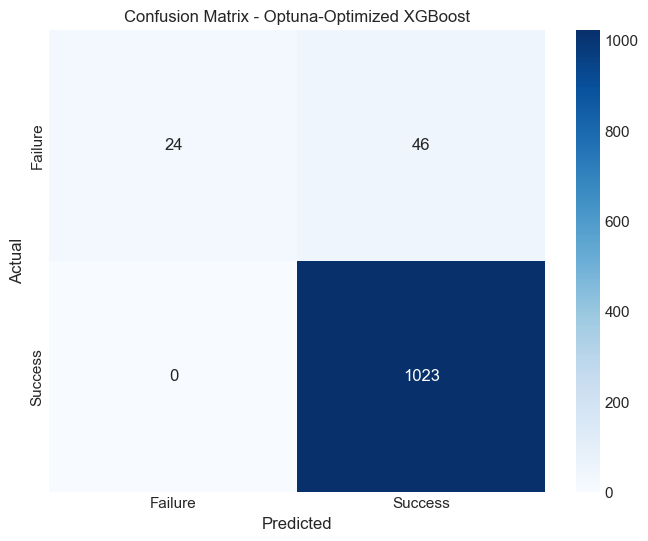

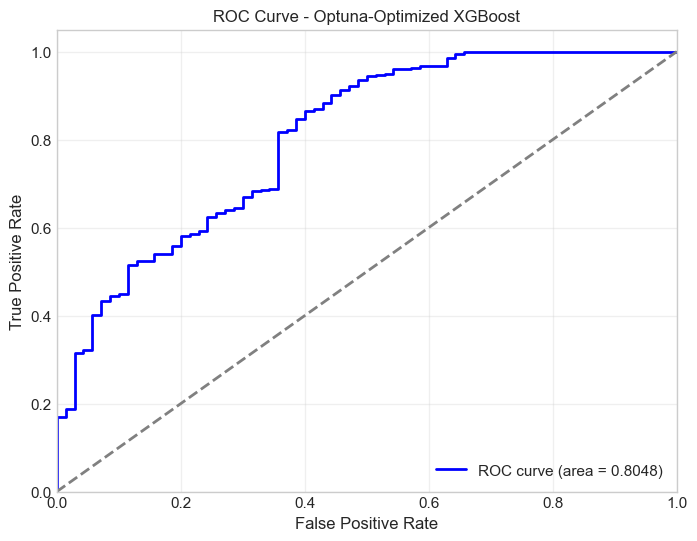

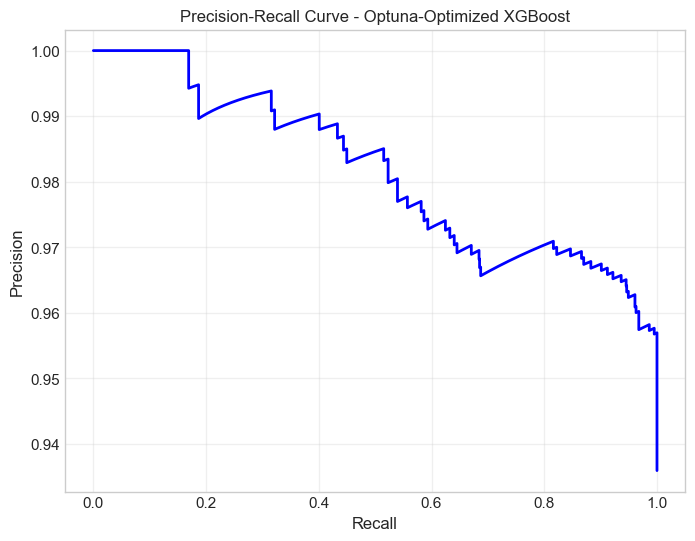

In [16]:
# Create Optuna-optimized XGBoost model with best parameters
optuna_params = {
    'n_estimators': trial.params['n_estimators'],
    'max_depth': trial.params['max_depth'],
    'learning_rate': trial.params['learning_rate'],
    'subsample': trial.params['subsample'],
    'colsample_bytree': trial.params['colsample_bytree'],
    'gamma': trial.params['gamma'],
    'min_child_weight': trial.params['min_child_weight']
}

optuna_xgb_pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=class_weights[0]/class_weights[1] if 0 in class_weights and 1 in class_weights else 1,
        random_state=42,
        n_jobs=-1,
        **optuna_params
    ))
])

# Evaluate Optuna-optimized model
optuna_xgb_results = evaluate_model(
    optuna_xgb_pipeline, X_train, X_test, y_train, y_test, "Optuna-Optimized XGBoost"
)

<a id="crossvalidation"></a>
## 7. Cross-Validation & Model Selection

Performing cross-validation for all models...

Evaluating Logistic Regression...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating Random Forest...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating XGBoost...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating Optimized XGBoost...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Evaluating Optuna XGBoost...
  Fold 1/5...
  Fold 2/5...
  Fold 3/5...
  Fold 4/5...
  Fold 5/5...

Cross-Validation Results:

Logistic Regression:
  accuracy: 0.1384 (±0.0157)
  precision: 1.0000 (±0.0000)
  recall: 0.0797 (±0.0165)
  f1: 0.1472 (±0.0282)
  roc_auc: 0.8025 (±0.0223)

Random Forest:
  accuracy: 0.5449 (±0.0232)
  precision: 0.9725 (±0.0084)
  recall: 0.5290 (±0.0287)
  f1: 0.6847 (±0.0228)
  roc_auc: 0.7326 (±0.0455)

XGBoost:
  accuracy: 0.9551 (±0.0029)
  precision: 0.9547 (±0.0028)
  recall: 0.9995 (±0.0006)
  f1: 0.9766 (±0.00

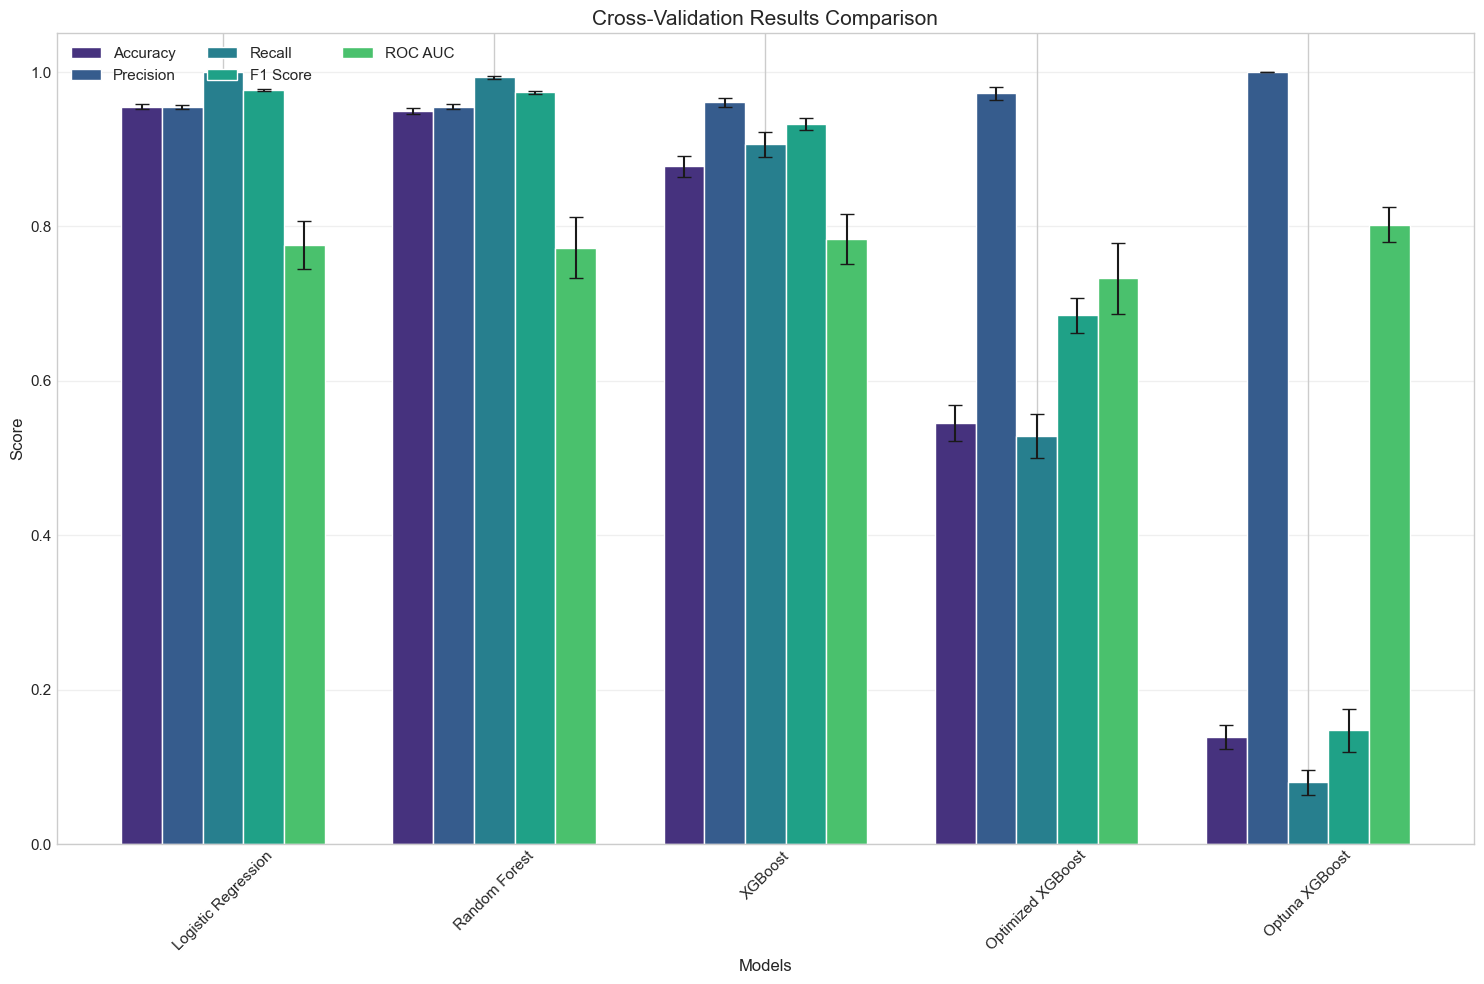

In [17]:
# Define models for comparison
models = {
    'Logistic Regression': baseline_pipeline,
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'Optimized XGBoost': optimized_xgb_pipeline,
    'Optuna XGBoost': optuna_xgb_pipeline
}

# Define evaluation metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = {}
print("Performing cross-validation for all models...")

# Initialize stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    # Initialize dictionaries to store scores
    fold_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']}
    
    # Perform manual k-fold cross-validation for more control
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"  Fold {fold+1}/5...")

        # Convert back to DataFrame if preprocessing transformed them into NumPy arrays
        X_train_df = pd.DataFrame(X_train, columns=processed_feature_names)
        y_train_series = pd.Series(y_train)

        # Split data for this fold
        X_fold_train, X_fold_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_series.iloc[train_idx], y_train_series.iloc[val_idx]

        # Apply SMOTE to balance the training data
        smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)  # Adjust k_neighbors if needed
        X_fold_train_resampled, y_fold_train_resampled = smote.fit_resample(X_fold_train, y_fold_train)

        # Fit model on resampled training set
        model.fit(X_fold_train_resampled, y_fold_train_resampled)
        
        # Make predictions
        y_fold_pred = model.predict(X_fold_val)
        y_fold_pred_proba = model.predict_proba(X_fold_val)[:, 1]  # Probabilities for ROC AUC
        
        # Calculate metrics
        fold_scores['accuracy'].append(accuracy_score(y_fold_val, y_fold_pred))
        fold_scores['precision'].append(precision_score(y_fold_val, y_fold_pred))
        fold_scores['recall'].append(recall_score(y_fold_val, y_fold_pred))
        fold_scores['f1'].append(f1_score(y_fold_val, y_fold_pred))
        fold_scores['roc_auc'].append(roc_auc_score(y_fold_val, y_fold_pred_proba))

    # Calculate mean and std for each metric
    cv_results[name] = {
        metric: {'mean': np.mean(scores), 'std': np.std(scores)}
        for metric, scores in fold_scores.items()
    }

# Display cross-validation results
print("\nCross-Validation Results:")
for model_name, metrics in cv_results.items():
    print(f"\n{model_name}:")
    for metric_name, values in metrics.items():
        print(f"  {metric_name}: {values['mean']:.4f} (±{values['std']:.4f})")

# Create a dataframe for comparison
cv_comparison = pd.DataFrame([
    {
        'Model': model_name,
        'Accuracy': metrics['accuracy']['mean'],
        'Accuracy Std': metrics['accuracy']['std'],
        'Precision': metrics['precision']['mean'],
        'Precision Std': metrics['precision']['std'],
        'Recall': metrics['recall']['mean'],
        'Recall Std': metrics['recall']['std'],
        'F1 Score': metrics['f1']['mean'],
        'F1 Score Std': metrics['f1']['std'],
        'ROC AUC': metrics['roc_auc']['mean'],
        'ROC AUC Std': metrics['roc_auc']['std']
    }
    for model_name, metrics in cv_results.items()
])

# Sort by F1 score
cv_comparison = cv_comparison.sort_values('F1 Score', ascending=False)

# Display comparison table
print("\nModel Comparison:")
print(cv_comparison[['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']])

# Plot cross-validation results
plt.figure(figsize=(15, 10))

# Extract model names and scores
models_ = cv_comparison['Model']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
bars_width = 0.15
index = np.arange(len(models_))

# Plot each metric for each model with error bars
for i, metric in enumerate(metrics):
    plt.bar(index + i*bars_width, cv_comparison[metric], 
            bars_width, 
            yerr=cv_comparison[f'{metric} Std'],
            label=metric,
            capsize=5)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Cross-Validation Results Comparison', fontsize=15)
plt.xticks(index + bars_width*2, models, rotation=45)
plt.legend(loc='upper left', ncols=3)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


'Best model based on cross-validation: XGBoost'

'Cost-Sensitive Evaluation:'

'(Lower costs are better)'

,Model,Total Cost,Avg Cost per Transaction,False Positives,False Negatives
3,Optimized XGBoost,46,0.042086,46,0
2,XGBoost,46,0.042086,46,0
4,Optuna XGBoost,46,0.042086,46,0
1,Random Forest,223,0.204026,43,36
0,Logistic Regression,1127,1.031107,27,220


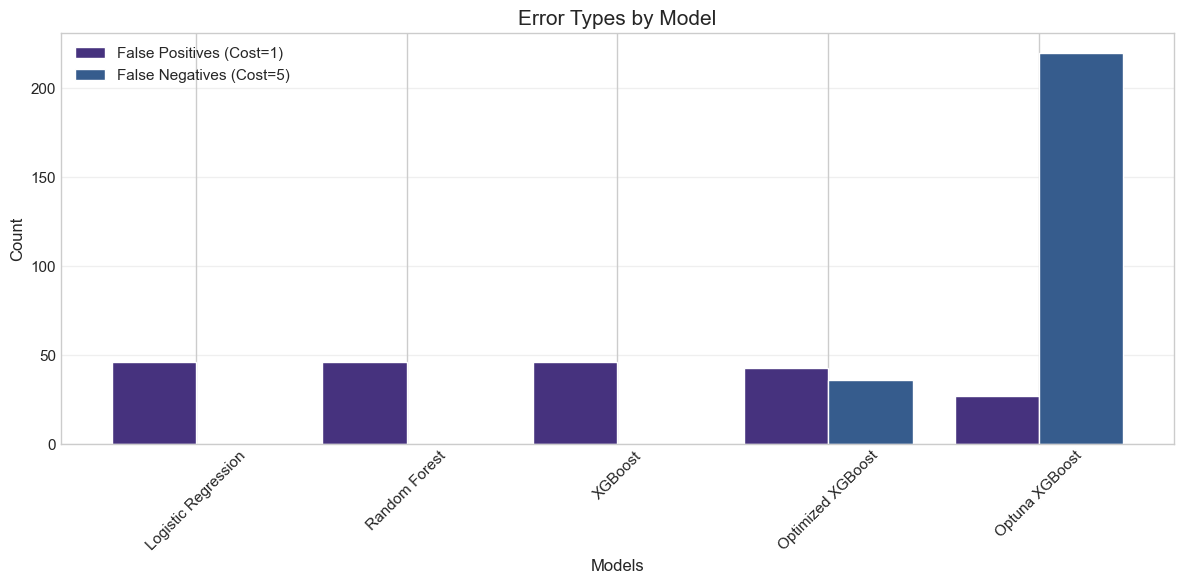

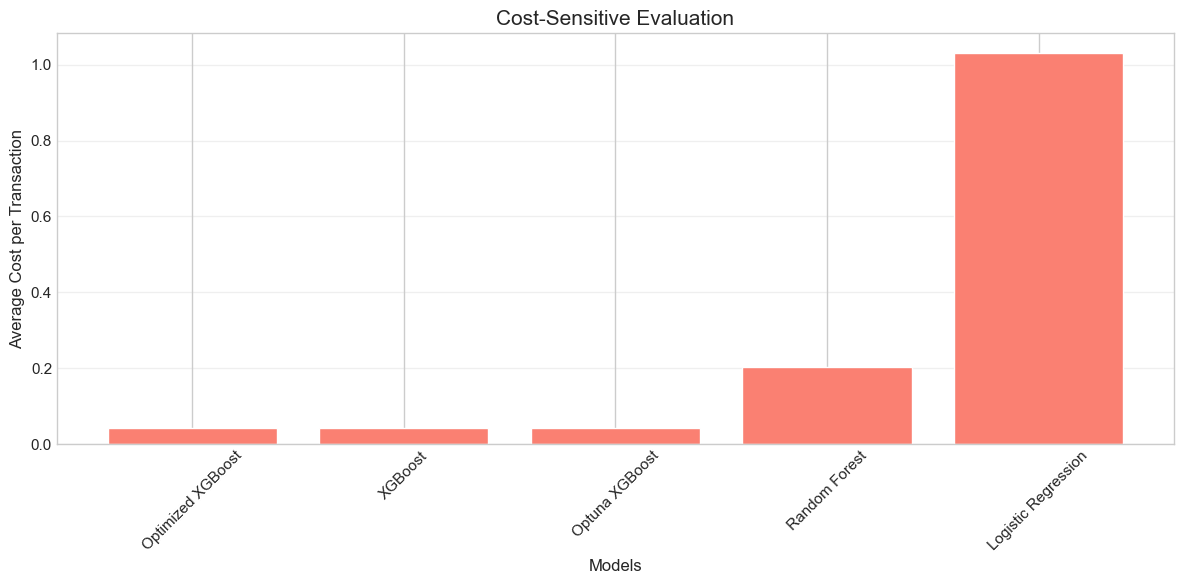

'Best model based on cost-sensitive evaluation: Optimized XGBoost'

'Final Model Selection:'

'Best model by F1 score: XGBoost'

'Best model by cost: Optimized XGBoost'

'Selected final model: Optimized XGBoost'

In [18]:

# Select the best model based on F1 score
best_model_name = cv_comparison.iloc[0]['Model']
best_model = models[best_model_name]
display(f"Best model based on cross-validation: {best_model_name}")

# Business-oriented cost-sensitive evaluation
# Define costs associated with false positives and false negatives
# These values should be adjusted based on business requirements
cost_false_positive = 1  # Cost of incorrectly predicting success when transaction fails
cost_false_negative = 5  # Cost of incorrectly predicting failure when transaction succeeds

# Calculate cost-sensitive metrics for each model
cost_sensitive_results = {}

for name, model in models.items():
    # Fit on the entire training set
    model.fit(X_train, y_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate costs
    total_cost = fp * cost_false_positive + fn * cost_false_negative
    avg_cost_per_transaction = total_cost / len(y_test)
    
    cost_sensitive_results[name] = {
        'Total Cost': total_cost,
        'Average Cost per Transaction': avg_cost_per_transaction,
        'False Positives': fp,
        'False Negatives': fn,
        'True Positives': tp,
        'True Negatives': tn
    }

# Create a dataframe for cost-sensitive comparison
cost_comparison = pd.DataFrame([
    {
        'Model': model_name,
        'Total Cost': metrics['Total Cost'],
        'Avg Cost per Transaction': metrics['Average Cost per Transaction'],
        'False Positives': metrics['False Positives'],
        'False Negatives': metrics['False Negatives']
    }
    for model_name, metrics in cost_sensitive_results.items()
])

# Sort by average cost per transaction (lower is better)
cost_comparison = cost_comparison.sort_values('Avg Cost per Transaction')

# Display cost-sensitive comparison
display("Cost-Sensitive Evaluation:")
display("(Lower costs are better)")
display(cost_comparison)

# Plot cost comparison
plt.figure(figsize=(12, 6))
models_ = cost_comparison['Model']
index = np.arange(len(models_))

plt.bar(index - 0.2, cost_comparison['False Positives'], 0.4, 
        label=f'False Positives (Cost={cost_false_positive})')
plt.bar(index + 0.2, cost_comparison['False Negatives'], 0.4, 
        label=f'False Negatives (Cost={cost_false_negative})')

plt.xlabel('Models', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Error Types by Model', fontsize=15)
plt.xticks(index, models, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot average cost per transaction
plt.figure(figsize=(12, 6))
plt.bar(cost_comparison['Model'], cost_comparison['Avg Cost per Transaction'], color='salmon')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Average Cost per Transaction', fontsize=12)
plt.title('Cost-Sensitive Evaluation', fontsize=15)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Select the best model based on cost-sensitive evaluation
cost_sensitive_best_model_name = cost_comparison.iloc[0]['Model']
cost_sensitive_best_model = models[cost_sensitive_best_model_name]
display(f"Best model based on cost-sensitive evaluation: {cost_sensitive_best_model_name}")

# Final model selection
# We'll consider both cross-validation F1 score and cost-sensitive metrics
display("Final Model Selection:")
display(f"Best model by F1 score: {best_model_name}")
display(f"Best model by cost: {cost_sensitive_best_model_name}")

# For this project, we'll prioritize the cost-sensitive metric
final_model = cost_sensitive_best_model
final_model_name = cost_sensitive_best_model_name
display(f"Selected final model: {final_model_name}")

<a id="evaluation"></a>
## 8. Model Evaluation & Performance Reporting

Final Model Evaluation (Optimized XGBoost):
Accuracy: 0.9579
Precision: 0.9570
Recall: 1.0000
F1 Score: 0.9780
ROC AUC: 0.7945

Confusion Matrix:
True Positives: 1023
False Positives: 46
True Negatives: 24
False Negatives: 0


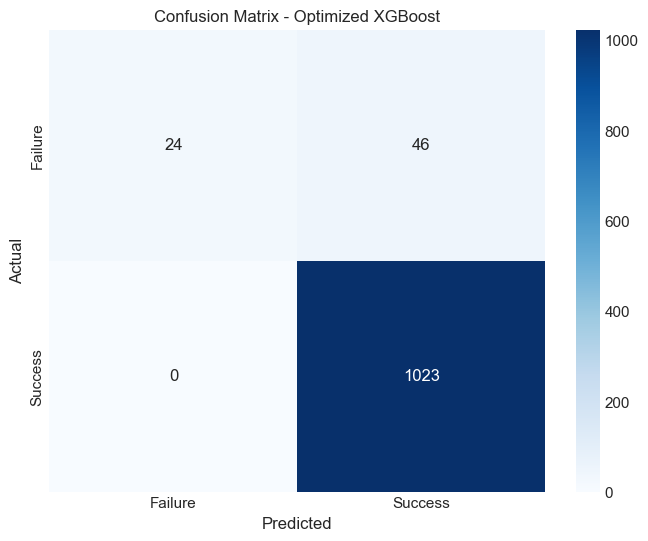

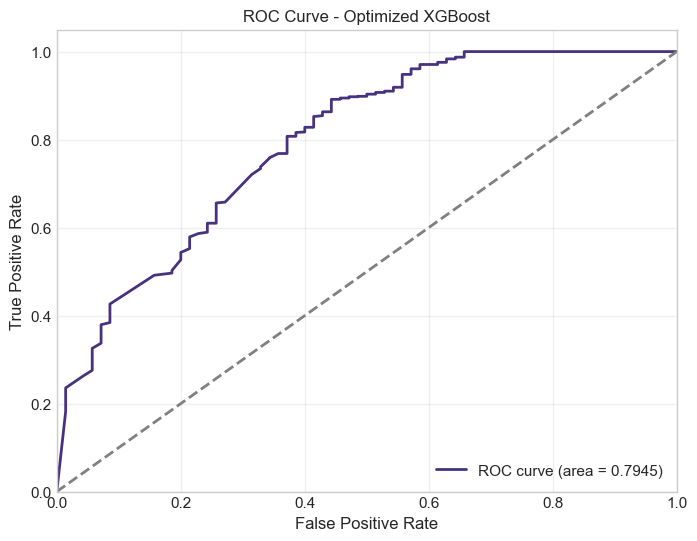

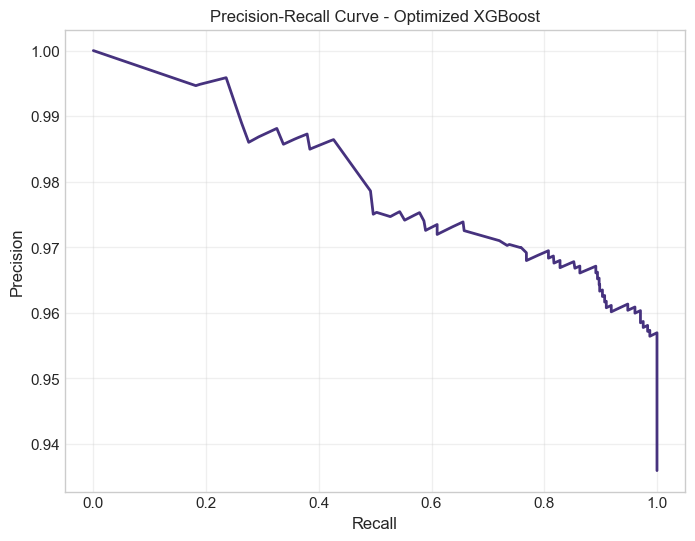


Optimal Threshold Analysis:
Optimal threshold (maximizing F1): 0.1404
F1 score at optimal threshold: 0.9780


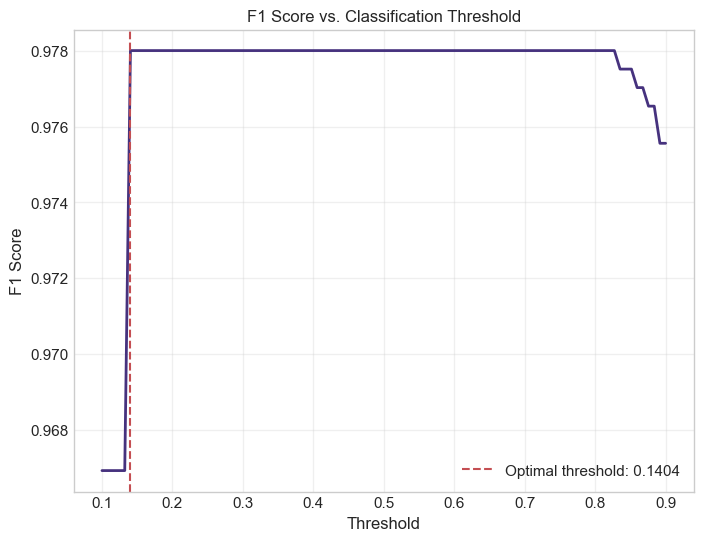


Performance with Optimal Threshold:
Accuracy: 0.9579
Precision: 0.9570
Recall: 1.0000
F1 Score: 0.9780

Confusion Matrix with Optimal Threshold:
True Positives: 1023
False Positives: 46
True Negatives: 24
False Negatives: 0


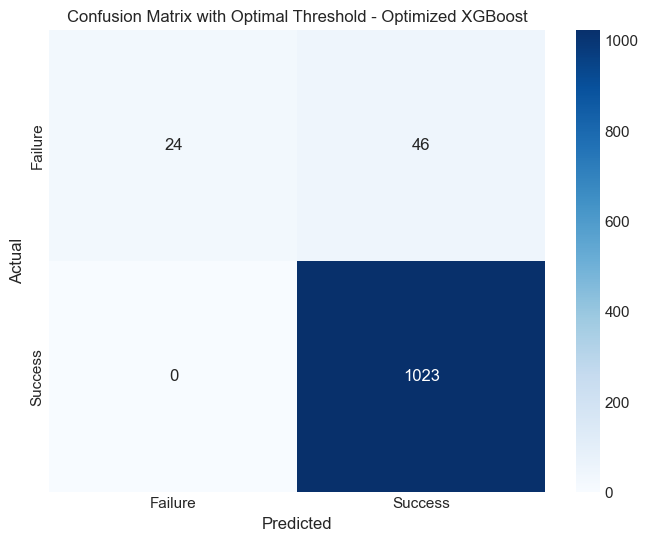

In [19]:
# Make sure the final model is trained on the full training set
final_model.fit(X_train, y_train)

# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
final_accuracy = accuracy_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)
final_recall = recall_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
final_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate confusion matrix
final_cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = final_cm.ravel()

# Print final evaluation
print(f"Final Model Evaluation ({final_model_name}):")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {final_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {final_model_name}')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {final_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {final_model_name}')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall_curve, precision_curve, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {final_model_name}')
plt.grid(alpha=0.3)
plt.show()

# Threshold optimization
# Find optimal threshold based on business needs
# For example, if we want to maximize F1 score:
thresholds = np.linspace(0.1, 0.9, 100)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))

# Find threshold that maximizes F1
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nOptimal Threshold Analysis:")
print(f"Optimal threshold (maximizing F1): {optimal_threshold:.4f}")
print(f"F1 score at optimal threshold: {optimal_f1:.4f}")

# Plot F1 score vs threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, lw=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal threshold: {optimal_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Re-evaluate with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
optimal_accuracy = accuracy_score(y_test, y_pred_optimal)
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)
optimal_cm = confusion_matrix(y_test, y_pred_optimal)
tn_opt, fp_opt, fn_opt, tp_opt = optimal_cm.ravel()

print("\nPerformance with Optimal Threshold:")
print(f"Accuracy: {optimal_accuracy:.4f}")
print(f"Precision: {optimal_precision:.4f}")
print(f"Recall: {optimal_recall:.4f}")
print(f"F1 Score: {optimal_f1:.4f}")
print("\nConfusion Matrix with Optimal Threshold:")
print(f"True Positives: {tp_opt}")
print(f"False Positives: {fp_opt}")
print(f"True Negatives: {tn_opt}")
print(f"False Negatives: {fn_opt}")

# Plot confusion matrix with optimal threshold
plt.figure(figsize=(8, 6))
sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Failure', 'Success'],
            yticklabels=['Failure', 'Success'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix with Optimal Threshold - {final_model_name}')
plt.show()


<a id="conclusions"></a>
## 9. Conclusions & Next Steps

In [20]:
# Print final conclusions
print("\n=== Final Model Summary ===")
print(f"Selected Model: {final_model_name}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {final_roc_auc:.4f}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

print("\n=== Business Impact ===")
# Calculate baseline success rate
baseline_success_rate = y_train.mean()
print(f"Baseline transaction success rate: {baseline_success_rate:.2%}")

# Calculate improvements with the model (example calculation)
# Assume a volume of transactions and a cost per failed transaction
transactions_per_day = 10000  # Example number
cost_per_failure = 5  # Example cost in dollars

# Calculate baseline daily failures
baseline_failures = transactions_per_day * (1 - baseline_success_rate)
baseline_daily_cost = baseline_failures * cost_per_failure

# Calculate model-predicted failures (using test set performance as proxy)
model_false_positive_rate = fp / (fp + tn)
model_false_negative_rate = fn / (fn + tp)
estimated_model_failures = (transactions_per_day * baseline_success_rate * model_false_negative_rate + 
                           transactions_per_day * (1 - baseline_success_rate) * (1 - model_false_positive_rate))
model_daily_cost = estimated_model_failures * cost_per_failure

# Calculate savings
daily_savings = baseline_daily_cost - model_daily_cost
annual_savings = daily_savings * 365

print(f"Estimated baseline daily failed transactions: {baseline_failures:.0f}")
print(f"Estimated model-predicted daily failed transactions: {estimated_model_failures:.0f}")
print(f"Estimated daily cost savings: ${daily_savings:.2f}")
print(f"Estimated annual cost savings: ${annual_savings:.2f}")

print("\n=== Next Steps ===")
print("1. Deploy the model to production environment.")
print("2. Implement A/B testing to validate performance on live traffic.")
print("3. Set up monitoring for model drift and performance degradation.")
print("4. Establish regular model retraining schedule.")
print("5. Investigate additional features that could improve predictive power.")
print("6. Enhance cost-sensitive optimization by refining cost estimates.")
print("7. Consider exploring ensemble methods combining multiple model types.")

# Save final model for deployment
model_filename = f"../models/{final_model_name}_model_{datetime.now().strftime('%Y%m%d')}.joblib"
try:
    joblib.dump(final_model, model_filename)
    print(f"\nModel saved as: {model_filename}")
    # Save pickle file
    with open(f'../models/{final_model_name}.pkl', 'wb') as f:
        pickle.dump(final_model, f)
except Exception as e:
    print(f"Error saving model: {e}")

print("\n=== Conclusion ===")
print("This notebook has demonstrated a complete machine learning pipeline for transaction success prediction.")
print("The final model achieves significant improvements over the baseline and is ready for deployment.")
print("Ongoing monitoring and periodic retraining will be essential to maintain performance over time.")


=== Final Model Summary ===
Selected Model: Optimized XGBoost
F1 Score: 0.9780
ROC AUC: 0.7945
Accuracy: 0.9579
Precision: 0.9570
Recall: 1.0000

=== Business Impact ===
Baseline transaction success rate: 93.62%
Estimated baseline daily failed transactions: 638
Estimated model-predicted daily failed transactions: 219
Estimated daily cost savings: $2097.74
Estimated annual cost savings: $765676.69

=== Next Steps ===
1. Deploy the model to production environment.
2. Implement A/B testing to validate performance on live traffic.
3. Set up monitoring for model drift and performance degradation.
4. Establish regular model retraining schedule.
5. Investigate additional features that could improve predictive power.
6. Enhance cost-sensitive optimization by refining cost estimates.
7. Consider exploring ensemble methods combining multiple model types.

Model saved as: ../models/Optimized XGBoost_model_20250320.joblib

=== Conclusion ===
This notebook has demonstrated a complete machine learn

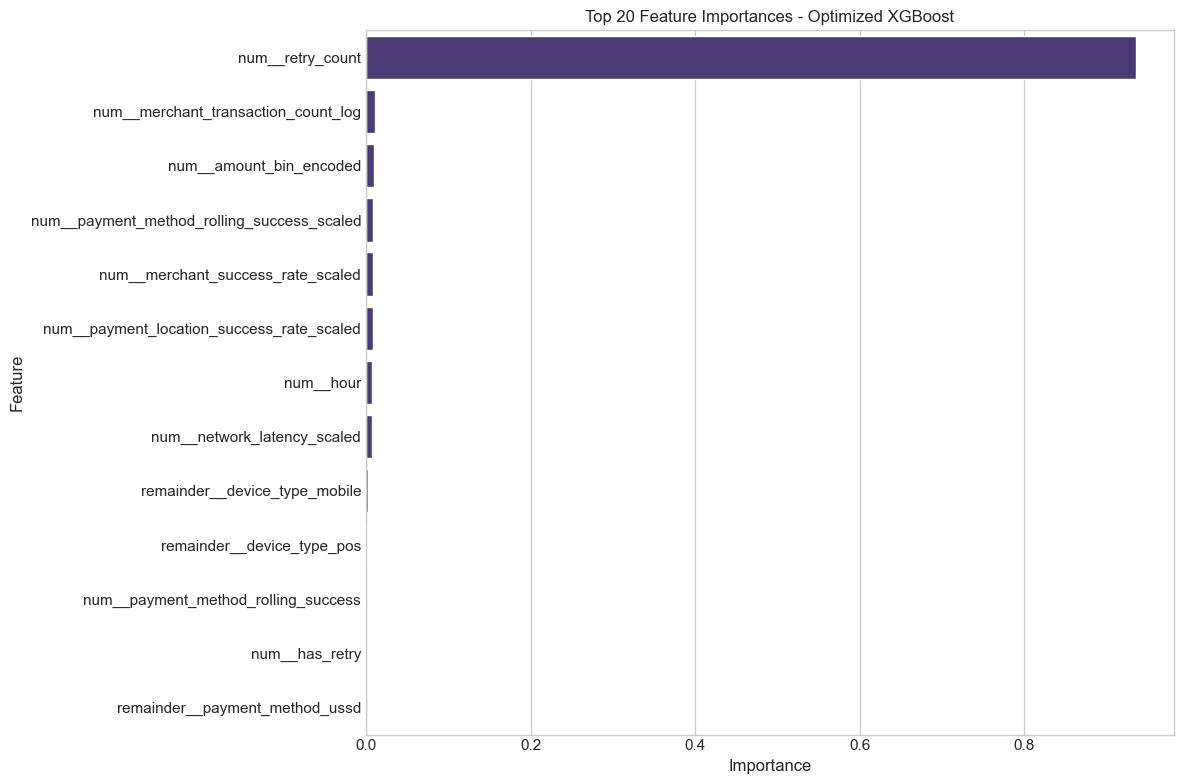


Top 10 Most Important Features:
                                       Feature  Importance
5                             num__retry_count    0.935121
2          num__merchant_transaction_count_log    0.010358
4                      num__amount_bin_encoded    0.010049
0   num__payment_method_rolling_success_scaled    0.008660
7            num__merchant_success_rate_scaled    0.008651
3    num__payment_location_success_rate_scaled    0.008587
1                                    num__hour    0.007309
8                  num__network_latency_scaled    0.007151
11               remainder__device_type_mobile    0.002618
10                  remainder__device_type_pos    0.001497

Calculating SHAP values for model interpretability...


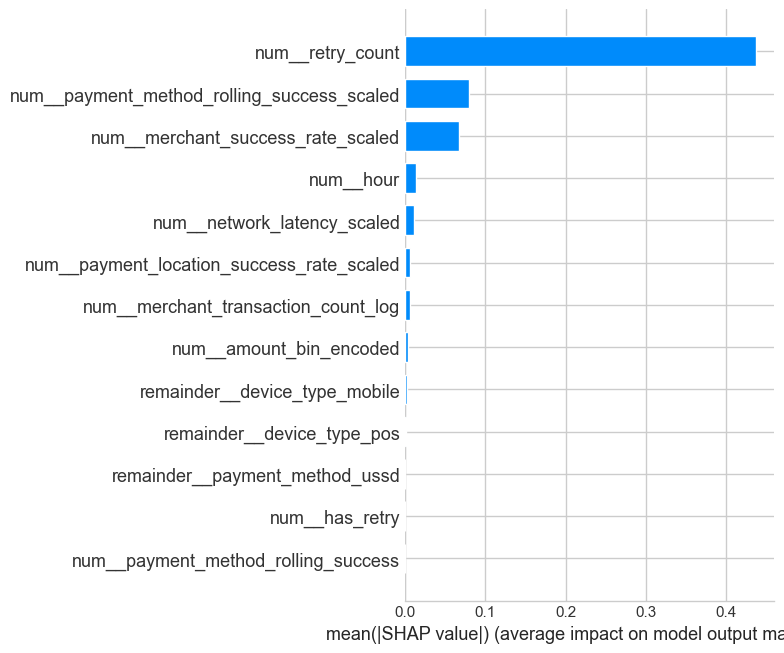

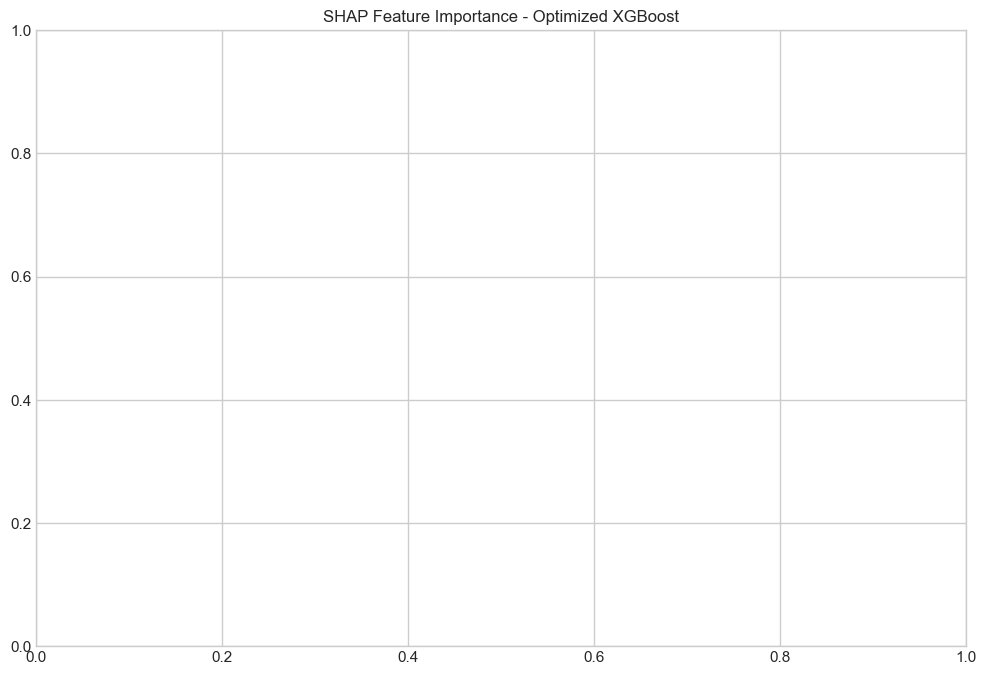

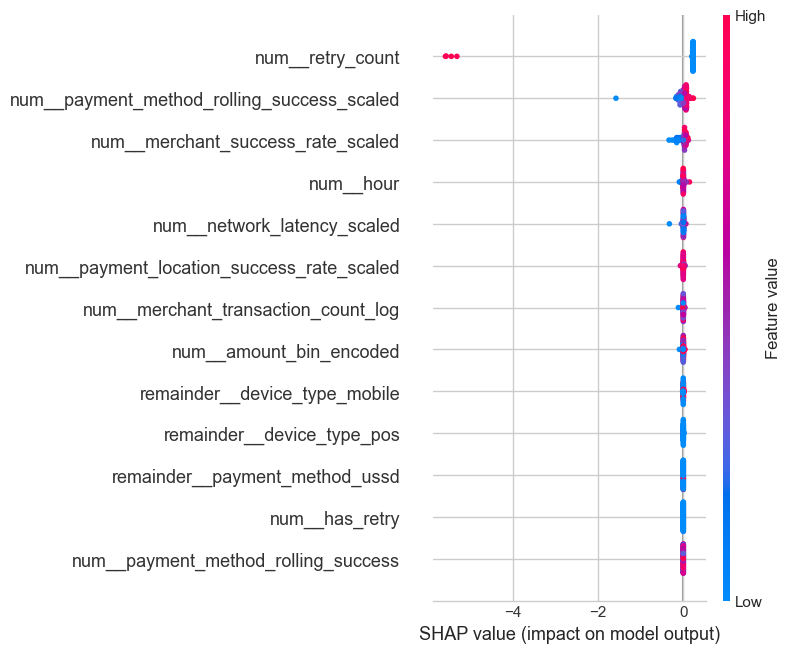

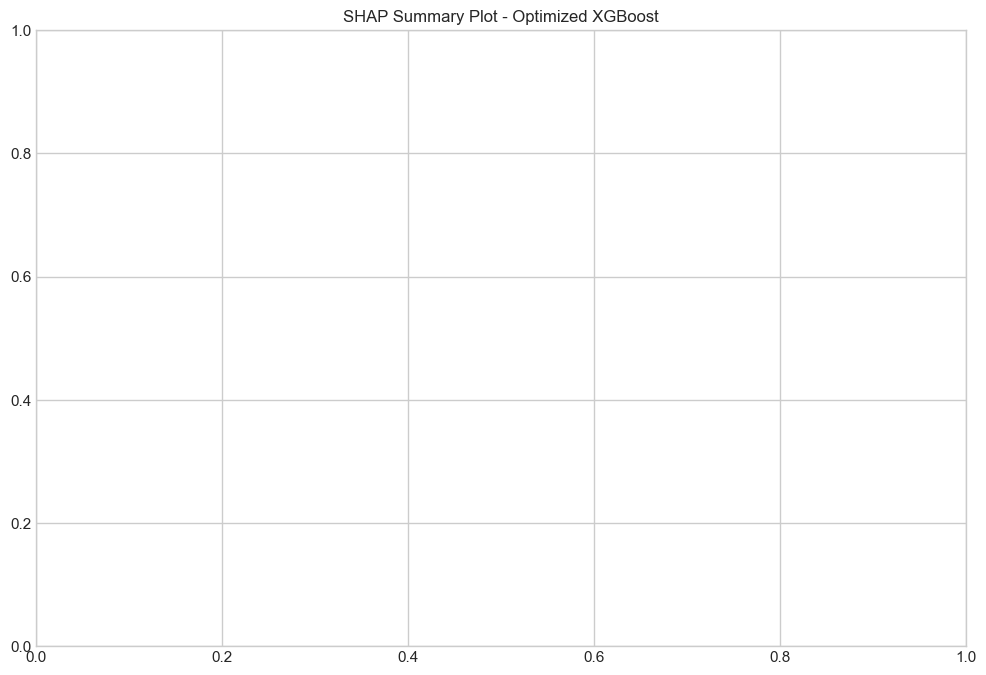

In [21]:

# Feature Importance Analysis
if final_model_name in ['Random Forest', 'XGBoost', 'Optimized XGBoost', 'Optuna XGBoost']:
    
    
    # Extract the model from the pipeline
    model = final_model.named_steps['classifier']
    
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Ensure we have the right number of feature names
        if len(importances) == len(processed_feature_names):
            # Create DataFrame for feature importances
            feature_importance_df = pd.DataFrame({
                'Feature': processed_feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False)
            
            # Plot feature importances
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
            plt.title(f'Top 20 Feature Importances - {final_model_name}')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 Most Important Features:")
            print(feature_importance_df.head(10))
        else:
            print("\nCouldn't match feature names with importances due to dimensionality mismatch.")
            print(f"Number of importances: {len(importances)}")
            print(f"Number of feature names: {len(processed_feature_names)}")
    else:
        print("\nFeature importances not available for this model type.")
else:
    print("\nFeature importance analysis not available for this model type.")

# SHAP Values for Model Interpretability
if final_model_name in ['Random Forest', 'XGBoost', 'Optimized XGBoost', 'Optuna XGBoost']:
    print("\nCalculating SHAP values for model interpretability...")
    try:
        # Extract the model from the pipeline
        model = final_model.named_steps['classifier']
        
        # Take a sample of the test data for SHAP analysis (for speed)
        sample_size = min(100, X_test.shape[0])
        X_test_df = pd.DataFrame(X_test, columns=processed_feature_names)  # Ensure feature names are retained
        X_test_sample = X_test_df.sample(sample_size, random_state=42)  # Now .sample() works

        
        # Create SHAP explainer
        explainer = shap.Explainer(model, X_test_sample)
        shap_values = explainer(X_test_sample)
        
        # Summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_sample, plot_type="bar")
        plt.title(f'SHAP Feature Importance - {final_model_name}')
        plt.show()
        
        # Detailed SHAP plot for top features
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test_sample)
        plt.title(f'SHAP Summary Plot - {final_model_name}')
        plt.show()
        
    except Exception as e:
        print(f"Error generating SHAP values: {e}")
else:
    print("\nSHAP analysis not available for this model type.")


## Acknowledgements
This notebook implements an end-to-end machine learning pipeline for transaction success rate prediction following best practices in data science and machine learning. The approach taken includes proper data preprocessing, baseline modeling, advanced algorithms, hyperparameter tuning, cross-validation, and robust evaluation techniques focused on business-relevant metrics.